In [1]:
%matplotlib inline
import os, collections
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import fisher_exact, spearmanr
from statsmodels.stats.multitest import fdrcorrection

rawData_path = "/home/jingbozhou/Project/CombDrug/runAddMut/9-plot/rawData/"
pathway_path = "/home/jingbozhou/Project/CombDrug/runAddMut/9-plot/1-NumberofData/drugPath/"

def returnPathNum(input_index):
    top_num_list = []
    for index in input_index:
        for item in index.split("/"):
            top_num_list.append(item)
    top_num_d = collections.Counter(top_num_list)
    
    return top_num_d.most_common()

In [2]:
### 1. Read drug combination data
raw_data = pd.read_table(os.path.join(rawData_path, "all_comb_data.tsv"))

## 1-1 drug pathway
drug_path = pd.read_csv(os.path.join(pathway_path, "drug_pathway.csv"), index_col="Drug_name").to_dict()['Pathway']
raw_data["Drug_row_path"] = raw_data["Drug_row"].map(drug_path)
raw_data["Drug_col_path"] = raw_data["Drug_col"].map(drug_path)

raw_data.head()

,DrugComb_id,Drug_row,Drug_row_cid,Drug_col,Drug_col_cid,Cell_line_name,RRID,DepMap_ID,ZIP,Bliss,Loewe,HSA,primary_disease,Drug_row_path,Drug_col_path
0,DrugComb_452435,Ethyl bromopyruvate,66144,717906-29-1,11598628,A-673,CVCL_0080,ACH-000052,-3.977,-11.357,-16.185,-12.450,Bone Cancer,Unknown,Kinase other
1,DrugComb_452439,thalidomide,5426,717906-29-1,11598628,A-673,CVCL_0080,ACH-000052,-5.042,-8.103,-17.150,-8.166,Bone Cancer,Apoptosis regulation,Kinase other
2,DrugComb_452440,CHEMBL3348980,73265376,717906-29-1,11598628,A-673,CVCL_0080,ACH-000052,-2.481,-5.367,-18.390,-5.774,Bone Cancer,Unknown,Kinase other
3,DrugComb_452442,Tanshinone IIA,164676,717906-29-1,11598628,A-673,CVCL_0080,ACH-000052,-0.570,-2.729,-17.101,-4.699,Bone Cancer,Others,Kinase other
4,DrugComb_452448,dacarbazine,135398738,717906-29-1,11598628,A-673,CVCL_0080,ACH-000052,-10.245,-27.480,-31.348,-28.056,Bone Cancer,DNA/RNA synthesis/replication,Kinase other


In [3]:
### 2. Write to combination pathway file
for syn_score in ["ZIP", "Bliss", "Loewe", "HSA"]:
    data_syn = raw_data.copy()
    
    #data_syn = data_syn[~(((data_syn["Drug_row_path"]=="Unknown")&\
                           #(data_syn["Drug_col_path"]=="Unknown"))|\
                          #((data_syn["Drug_row_path"]=="Others")&\
                           #(data_syn["Drug_col_path"]=="Others")))].copy()
    
    data_syn.loc[data_syn[syn_score]> 10, "Synergy"] = "Yes"
    data_syn = data_syn.replace({"Synergy":{np.nan:"No"}})
    
    data_syn = data_syn.drop(columns=["Drug_row_cid", "Drug_col_cid", "RRID", "DepMap_ID", 
                                      "ZIP", "Bliss", "Loewe", "HSA"])
    data_syn.to_csv(os.path.join(pathway_path, "data_{}_tmp.tsv".format(syn_score)), sep="\t", index=0)
    
    out_file = open(os.path.join(pathway_path, "data_{}.tsv".format(syn_score)), "w")
    with open(os.path.join(pathway_path, "data_{}_tmp.tsv".format(syn_score))) as f:
        out_file.write("\t".join(f.readline().rstrip().split("\t")+["Comb_pathway"])+'\n')
        already_path = set()
        for line in f:
            line = line.rstrip().split("\t")
            Drug_row_path = line[5]
            Drug_col_path = line[6]
        
            path_tmp_1 = Drug_row_path + "+" + Drug_col_path
            path_tmp_2 = Drug_col_path + "+" + Drug_row_path
            if path_tmp_1 in already_path:
                path_tmp = path_tmp_1
            elif path_tmp_2 in already_path:
                path_tmp = path_tmp_2
            else:
                path_tmp = path_tmp_1
                already_path.add(path_tmp)
        
            out_file.write("\t".join(line+[path_tmp])+'\n')
    
    out_file.close()

In [4]:
### 3. Get p-value and odd ratios
for syn_score in ["ZIP", "Bliss", "Loewe", "HSA"]:
    out_file = open(os.path.join(pathway_path, "pathway_p_value_{}.tsv".format(syn_score)), "w")
    out_file.write("\t".join(["Comb_pathway", "primary_disease", 
                              "++", "+-", "-+", "--",
                              "OR", "PValue"])+"\n")

    data_syn_all = pd.read_table(os.path.join(pathway_path, "data_{}.tsv".format(syn_score)))
    cancer_type_list = ['Skin Cancer', 'Lung Cancer', 'Breast Cancer', 
                        'Ovarian Cancer', 'Brain Cancer','Kidney Cancer',
                        'Colon Cancer', "Others", "All"]
    for cancer_type in cancer_type_list:
        if cancer_type == "All":
            data_syn_type = data_syn_all
        elif cancer_type == "Others":
            data_syn_type = data_syn_all[~data_syn_all["primary_disease"].isin(cancer_type_list[:-2])]
        else:
            data_syn_type = data_syn_all[data_syn_all["primary_disease"]==cancer_type]
        
        total_syn = (data_syn_type["Synergy"]=="Yes").sum()
        total_no = (data_syn_type["Synergy"]=="No").sum()
    
        for comb_path in data_syn_type["Comb_pathway"].unique():
            data_type_path = data_syn_type[data_syn_type["Comb_pathway"]==comb_path]
            path_syn = (data_type_path["Synergy"]=="Yes").sum()
            path_no = (data_type_path["Synergy"]=="No").sum()
        
            oddsratio, p_val = fisher_exact([[path_syn, total_syn-path_syn], 
                                             [path_no, total_no-path_no]], 
                                            alternative="greater")
            out_file.write("\t".join([comb_path, cancer_type, 
                                  str(path_syn), str(total_syn-path_syn),
                                  str(path_no), str(total_no-path_no),
                                  str(oddsratio), str(p_val)])+"\n")
        
    out_file.close()

In [3]:
### Get result

def retrunORData(synerg_score):
    
    cancer_type_list = ['Skin Cancer', 'Lung Cancer', 'Breast Cancer', 
                        'Ovarian Cancer', 'Colon Cancer', 'Kidney Cancer',
                        'Brain Cancer']
    
    comb_path_res = pd.read_table(os.path.join(pathway_path, "pathway_p_value_{}.tsv".format(syn_score)))
    _, FDR = fdrcorrection(comb_path_res["PValue"].values)
    comb_path_res["FDR"] = FDR
    
    comb_path_sel = comb_path_res[(comb_path_res["PValue"] <= 0.005)&\
                                  (comb_path_res["FDR"] <= 0.05)&\
                                  (comb_path_res["OR"] != np.inf)]
    
    comb_path_sel = comb_path_sel[comb_path_sel["primary_disease"].isin(cancer_type_list)]
    
    comb_path_wide = comb_path_sel.pivot(index="Comb_pathway", columns="primary_disease", values="OR")
    comb_path_wide = comb_path_wide[cancer_type_list]
    index_order = comb_path_wide.count(axis=1).sort_values(ascending=False).index
    comb_path_wide = comb_path_wide.loc[index_order]
    
    comb_path_wide = comb_path_wide.rename(columns={x:x.split(" ")[0] for x in comb_path_wide.columns})
    
    return comb_path_wide

OR_ZIP = retrunORData("ZIP")
OR_Loewe = retrunORData("Loewe")
OR_Bliss = retrunORData("Bliss")
OR_HSA = retrunORData("HSA")

all_in_index = list(set(OR_ZIP.index).intersection(OR_Loewe.index).intersection(OR_Bliss.index).intersection(OR_HSA.index))

all_union_index = list(set(OR_ZIP.index).union(OR_Loewe.index).union(OR_Bliss.index).union(OR_HSA.index))

#with pd.ExcelWriter("./plotFigure/Table_S2_or_synery_metrics.xlsx") as writer:
    #OR_ZIP.to_excel(writer, sheet_name="ZIP", na_rep="Not Sig.")
    #OR_Loewe.to_excel(writer, sheet_name="Loewe", na_rep="Not Sig.")
    #OR_Bliss.to_excel(writer, sheet_name="Bliss", na_rep="Not Sig.")
    #OR_HSA.to_excel(writer, sheet_name="HSA", na_rep="Not Sig.")

In [3]:
OR_ZIP.shape, OR_Loewe.shape, OR_Bliss.shape, OR_HSA.shape, len(all_in_index), len(all_union_index)

((101, 7), (76, 7), (103, 7), (86, 7), 68, 110)

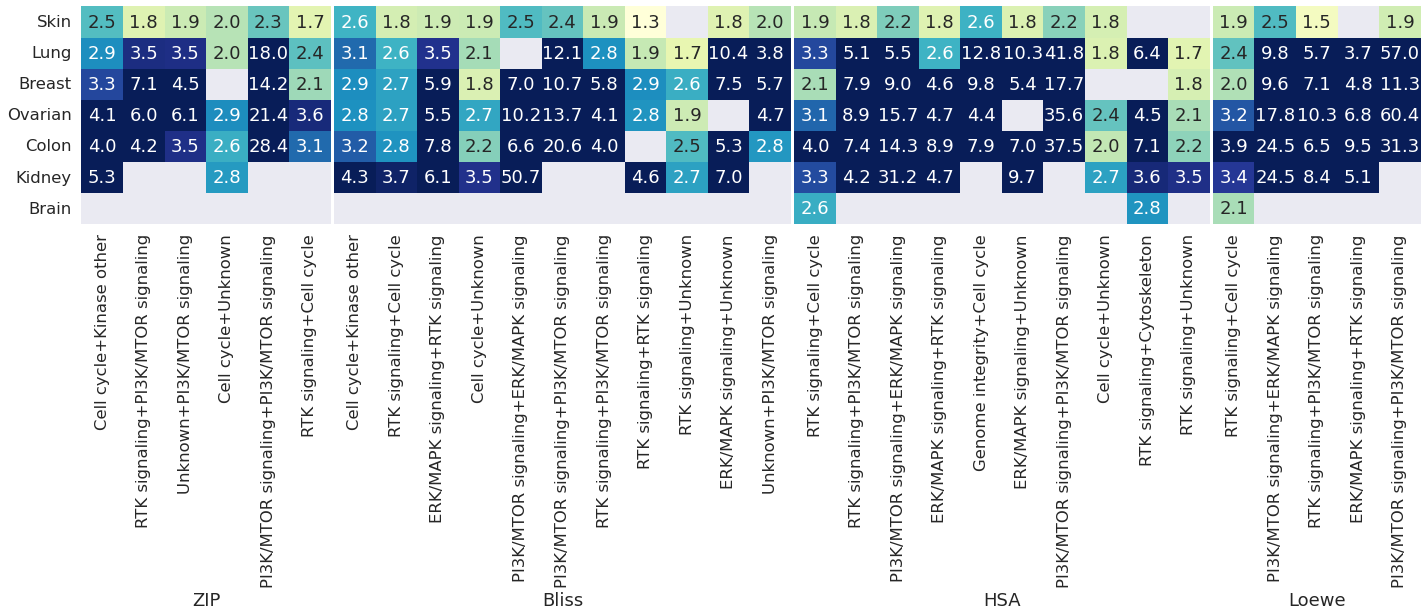

In [28]:
comb_ZIP = OR_ZIP.iloc[:(OR_ZIP.count(axis=1)>= 5).sum()].T
comb_Bliss = OR_Bliss.iloc[:(OR_Bliss.count(axis=1)>= 5).sum()].T
comb_Loewe = OR_Loewe.iloc[:(OR_Loewe.count(axis=1)>= 5).sum()].T
comb_HSA = OR_HSA.iloc[:(OR_HSA.count(axis=1)>= 5).sum()].T

vmin = min(comb_ZIP.min().min(), comb_Bliss.min().min(), comb_Loewe.min().min(), comb_HSA.min().min())
vmax = max(comb_ZIP.min().max(), comb_Bliss.min().max(), comb_Loewe.min().max(), comb_HSA.min().max())

sns.set(font_scale=1.5, rc={'figure.figsize':(24, 4)})
fig, axes = plt.subplots(nrows=1, ncols=4, gridspec_kw=dict(width_ratios=[comb_ZIP.shape[1], 
                                                                           comb_Bliss.shape[1], 
                                                                           comb_HSA.shape[1], 
                                                                           comb_Loewe.shape[1]]))

sns.heatmap(comb_ZIP, annot=True, fmt=".1f", cmap="YlGnBu", ax=axes[0], vmin=vmin, vmax=vmax, cbar=False)
axes[0].set(xlabel="ZIP", ylabel="")

sns.heatmap(comb_Bliss, annot=True, fmt=".1f", cmap="YlGnBu", ax=axes[1], vmin=vmin, vmax=vmax, cbar=False)
axes[1].set(xlabel="Bliss", ylabel="", yticklabels=[])

sns.heatmap(comb_HSA, annot=True, fmt=".1f", cmap="YlGnBu", ax=axes[2], vmin=vmin, vmax=vmax, cbar=False)
axes[2].set(xlabel="HSA", ylabel="", yticklabels=[])

sns.heatmap(comb_Loewe, annot=True, fmt=".1f", cmap="YlGnBu", ax=axes[3], vmin=vmin, vmax=vmax, cbar=False)
axes[3].set(xlabel="Loewe", ylabel="", yticklabels=[])

fig.subplots_adjust(wspace=0.01)

#plt.savefig("./plotFigure/drug_pathway_four_score.svg", format="svg", bbox_inches="tight", transparent=True)